In [25]:
# Importing necessary libraries
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [26]:
# Read the CSV file
dataset = pd.read_csv(r'C:\Users\math_\OneDrive\Documentos\7VFI.AI1\Cleaned Data\cleaned-data\ethereum-pools-volume-cleaned.csv')
dataset

,daily_volume,time,total_volume,Pool-Name,running_total_by_pool
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07
...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11


In [27]:
# Split column 'Pool-Name' into three columns: 'Token_1', 'Token_2' and 'Fee's'
crypto_info = dataset['Pool-Name'].str.split(' ', n=2, expand=True)
dataset['Token_1'] = crypto_info[0]
dataset['Token_2'] = crypto_info[2].str.split(' ', n=1, expand=True)[0]

# Create columns for each rate type
dataset['fee_0.01%'] = 0
dataset['fee_0.05%'] = 0
dataset['fee_0.3%'] = 0
dataset['fee_1%'] = 0

# Assign the correct values to the fee columns
dataset.loc[dataset['Pool-Name'].str.contains('0.01%'), 'fee_0.01%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.05%'), 'fee_0.05%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.3%'), 'fee_0.3%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('1%'), 'fee_1%'] = 1

# printing to see the results
dataset

,daily_volume,time,total_volume,Pool-Name,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04,DAI,ETH,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06,DAI,ETH,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06,DAI,ETH,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07,DAI,ETH,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07,DAI,ETH,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11,ETH,USDC,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11,ETH,USDC,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11,ETH,USDC,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11,ETH,USDC,0,1,0,0


In [28]:
# Token-to-number mapping dictionary
token_dict = {'DAI': 0, 'ETH': 1, 'LUSD': 2, 'USDC': 3, 'UDT': 4, 'MATIC': 5, 'WBTC': 6, 'USDT': 7, 'LINK': 8, 'OP': 9, 'ARB': 10, 'WETH': 11, 'BUSD': 12, 'BNB': 13}

# Mapping tokens to numbers in column 'Token_1'
dataset['Token_1'] = dataset['Token_1'].map(token_dict)

# Mapping tokens to numbers in column 'Token_2'
dataset['Token_2'] = dataset['Token_2'].map(token_dict)

dataset

,daily_volume,time,total_volume,Pool-Name,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04,0,1,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06,0,1,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06,0,1,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07,0,1,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11,1,3,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11,1,3,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11,1,3,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11,1,3,0,1,0,0


In [29]:
# Removing the column 'Pool-Name' because the infos are now splited
dataset = dataset.drop(columns=['Pool-Name'])
dataset

,daily_volume,time,total_volume,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,8.568270e+04,0,1,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,1.517149e+06,0,1,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,9.976948e+06,0,1,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,1.631882e+07,0,1,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,3.750031e+11,1,3,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,3.751546e+11,1,3,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,3.753502e+11,1,3,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,3.754934e+11,1,3,0,1,0,0


In [30]:
# Convert 'time' column to datetime format
dataset['time'] = pd.to_datetime(dataset['time'])

# Set 'time' column as the index of the DataFrame
dataset.set_index('time', inplace=True)
dataset

,daily_volume,total_volume,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
time,,,,,,,,,
2021-05-05 00:00:00+00:00,8.568270e+04,8.568270e+04,8.568270e+04,0,1,0,1,0,0
2021-05-06 00:00:00+00:00,1.431467e+06,1.517149e+06,1.517149e+06,0,1,0,1,0,0
2021-05-07 00:00:00+00:00,8.459799e+06,9.976948e+06,9.976948e+06,0,1,0,1,0,0
2021-05-08 00:00:00+00:00,6.341874e+06,1.631882e+07,1.631882e+07,0,1,0,1,0,0
2021-05-09 00:00:00+00:00,2.707201e+05,1.658954e+07,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2023-05-22 00:00:00+00:00,1.432193e+08,3.750031e+11,3.750031e+11,1,3,0,1,0,0
2023-05-23 00:00:00+00:00,1.514438e+08,3.751546e+11,3.751546e+11,1,3,0,1,0,0
2023-05-24 00:00:00+00:00,1.956226e+08,3.753502e+11,3.753502e+11,1,3,0,1,0,0


In [31]:
# Check for null values (for your information)
null_count = dataset.isnull().sum()

In [32]:
# Group by 'time' and calculate the mean for 'total_volume'
grouped_dataset = dataset.groupby("time")
data = grouped_dataset["total_volume"].mean()

In [33]:
# Separating last 50 rows as the test data
data_train = data.iloc[:len(data)-50]
data_test = data.iloc[len(data_train):]

In [34]:
# Normalize the data between 0-1
data_train = np.array(data_train).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_train)

In [35]:
# Prepare training data
timestep = 50
x_train = []
y_train = []
for i in range(timestep, data_scaled.shape[0]):
    x_train.append(data_scaled[i-timestep:i, 0])
    y_train.append(data_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [36]:
# Build LSTM model
model = Sequential()
model.add(LSTM(10, input_shape=(None, 1), activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [37]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0)

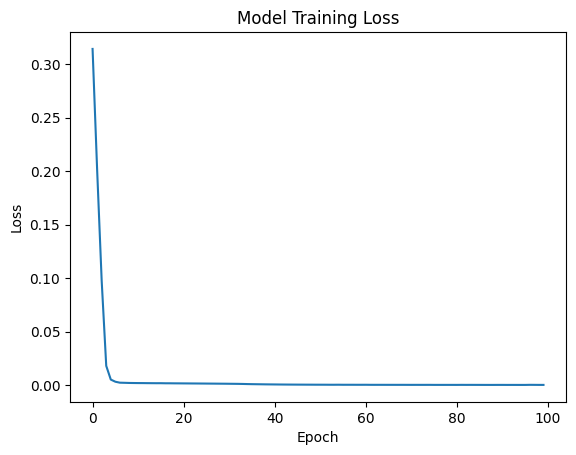

In [45]:
# Plotting the training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [46]:
# Prepare the test data just like the train data
inputs = data[len(data) - len(data_test) - 50:]
inputs = inputs.values.reshape(-1, 1)
inputs = scaler.transform(inputs)


In [47]:

x_test = []
for i in range(50, inputs.shape[0]):
    x_test.append(inputs[i-50:i, 0])
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)



In [48]:
# Make predictions
predicted_data = model.predict(x_test)
predicted_data = scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))



2/2 [==============================] - 0s 8ms/step


In [49]:
# Calculate the metrics
true_data = np.array(data_test).reshape(-1, 1)
mse = mean_squared_error(true_data, predicted_data)
mae = mean_absolute_error(true_data, predicted_data)
r2 = r2_score(true_data, predicted_data)



In [50]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

MSE: 3.752076927351855e+19
MAE: 2893578168.148431
R2 Score: -0.3176857910261539
